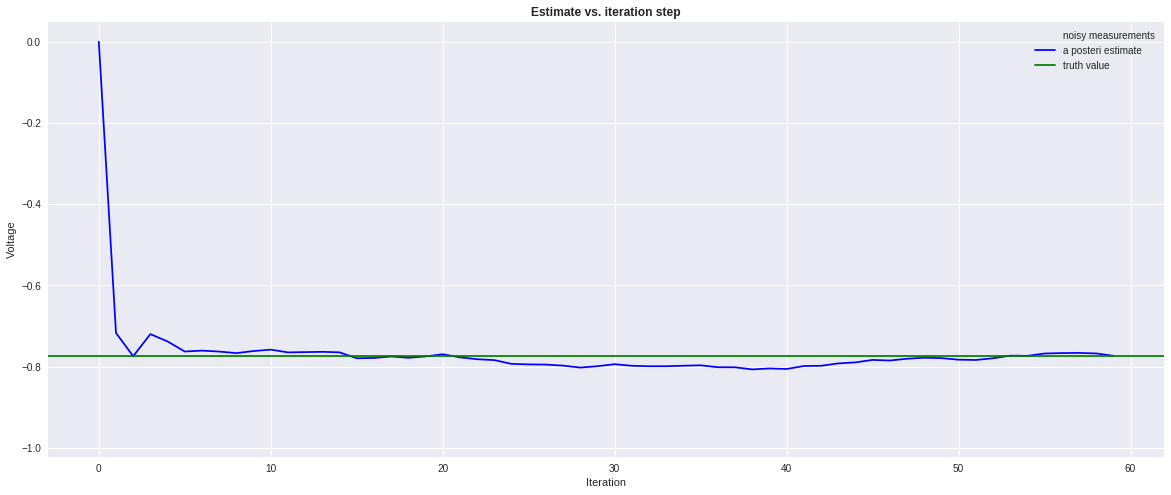

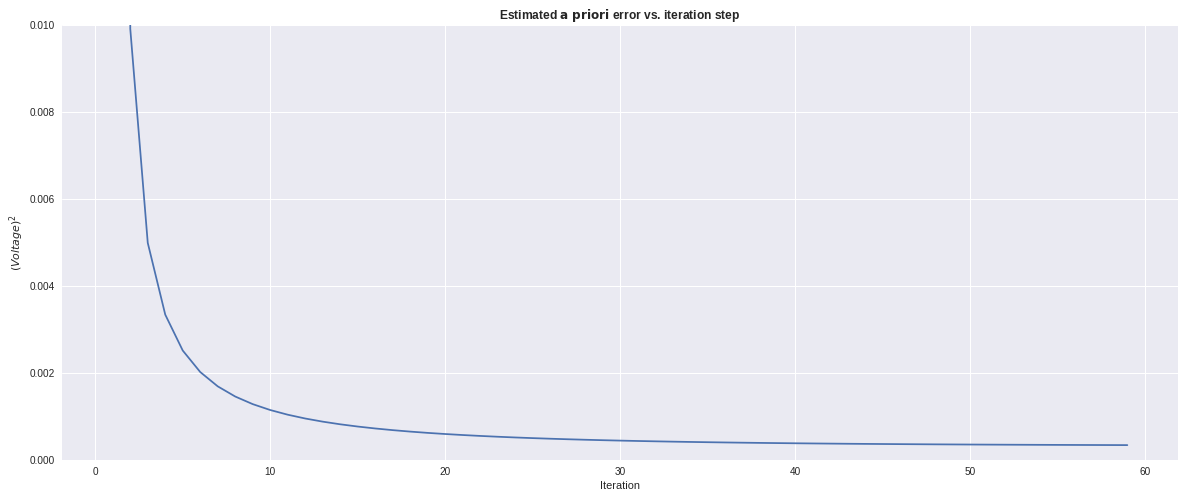

In [0]:
# Kalman filter example demo in Python

# A Python implementation of the example given in pages 11-15 of "An
# Introduction to the Kalman Filter" by Greg Welch and Gary Bishop,
# University of North Carolina at Chapel Hill, Department of Computer
# Science, TR 95-041,
# http://www.cs.unc.edu/~welch/kalman/kalmanIntro.html

# by Andrew D. Straw

import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (20, 8)

# intial parameters
n_iter = 60
sz = (n_iter,) # size of array
x = -0.7727 # truth value (typo in example at top of p. 13 calls this z)
z = np.random.normal(x,0.1,size=sz) # observations (normal about x, sigma=0.1)

Q = 1e-5 # process variance

# allocate space for arrays
xhat=np.zeros(sz)      # a posteri estimate of x
P=np.zeros(sz)         # a posteri error estimate
xhatminus=np.zeros(sz) # a priori estimate of x
Pminus=np.zeros(sz)    # a priori error estimate
K=np.zeros(sz)         # gain or blending factor

R = 0.1**2 # estimate of measurement variance, change to see effect

# intial guesses
xhat[0] = 0.0
P[0] = 1.0

for k in range(1,n_iter):
    # time update
    xhatminus[k] = xhat[k-1]
    Pminus[k] = P[k-1]+Q

    # measurement update
    K[k] = Pminus[k]/( Pminus[k]+R )
    xhat[k] = xhatminus[k]+K[k]*(z[k]-xhatminus[k])
    P[k] = (1-K[k])*Pminus[k]

plt.figure()
plt.plot(z,'k+',label='noisy measurements')
plt.plot(xhat,'b-',label='a posteri estimate')
plt.axhline(x,color='g',label='truth value')
plt.legend()
plt.title('Estimate vs. iteration step', fontweight='bold')
plt.xlabel('Iteration')
plt.ylabel('Voltage')

plt.figure()
valid_iter = range(1,n_iter) # Pminus not valid at step 0
plt.plot(valid_iter,Pminus[valid_iter],label='a priori error estimate')
plt.title('Estimated $\it{\mathbf{a \ priori}}$ error vs. iteration step', fontweight='bold')
plt.xlabel('Iteration')
plt.ylabel('$(Voltage)^2$')
plt.setp(plt.gca(),'ylim',[0,.01])
plt.show()

UKF : https://github.com/balghane/pyUKF

In [4]:
!git clone https://github.com/balghane/pyUKF.git
!ls pyUKF
#!cp pyUKF/example.csv .
!ls

Cloning into 'pyUKF'...
remote: Enumerating objects: 74, done.
remote: Total 74 (delta 0), reused 0 (delta 0), pack-reused 74
Unpacking objects: 100% (74/74), done.


In [0]:
import numpy as np
import scipy.linalg
from copy import deepcopy
from threading import Lock


class UKFException(Exception):
    """Raise for errors in the UKF, usually due to bad inputs"""


class UKF:
    def __init__(self, num_states, process_noise, initial_state, initial_covar, alpha, k, beta, iterate_function):
        """
        Initializes the unscented kalman filter
        :param num_states: int, the size of the state
        :param process_noise: the process noise covariance per unit time, should be num_states x num_states
        :param initial_state: initial values for the states, should be num_states x 1
        :param initial_covar: initial covariance matrix, should be num_states x num_states, typically large and diagonal
        :param alpha: UKF tuning parameter, determines spread of sigma points, typically a small positive value
        :param k: UKF tuning parameter, typically 0 or 3 - num_states
        :param beta: UKF tuning parameter, beta = 2 is ideal for gaussian distributions
        :param iterate_function: function that predicts the next state
                    takes in a num_states x 1 state and a float timestep
                    returns a num_states x 1 state
        """
        self.n_dim = int(num_states)
        self.n_sig = 1 + num_states * 2
        self.q = process_noise
        self.x = initial_state
        self.p = initial_covar
        self.beta = beta
        self.alpha = alpha
        self.k = k
        self.iterate = iterate_function

        self.lambd = pow(self.alpha, 2) * (self.n_dim + self.k) - self.n_dim

        self.covar_weights = np.zeros(self.n_sig)
        self.mean_weights = np.zeros(self.n_sig)

        self.covar_weights[0] = (self.lambd / (self.n_dim + self.lambd)) + (1 - pow(self.alpha, 2) + self.beta)
        self.mean_weights[0] = (self.lambd / (self.n_dim + self.lambd))

        for i in range(1, self.n_sig):
            self.covar_weights[i] = 1 / (2*(self.n_dim + self.lambd))
            self.mean_weights[i] = 1 / (2*(self.n_dim + self.lambd))

        self.sigmas = self.__get_sigmas()

        self.lock = Lock()

    def __get_sigmas(self):
        """generates sigma points"""
        ret = np.zeros((self.n_sig, self.n_dim))

        tmp_mat = (self.n_dim + self.lambd)*self.p

        # print spr_mat
        spr_mat = scipy.linalg.sqrtm(tmp_mat)

        ret[0] = self.x
        for i in range(self.n_dim):
            ret[i+1] = self.x + spr_mat[i]
            ret[i+1+self.n_dim] = self.x - spr_mat[i]

        return ret.T

    def update(self, states, data, r_matrix):
        """
        performs a measurement update
        :param states: list of indices (zero-indexed) of which states were measured, that is, which are being updated
        :param data: list of the data corresponding to the values in states
        :param r_matrix: error matrix for the data, again corresponding to the values in states
        """

        self.lock.acquire()

        num_states = len(states)

        # create y, sigmas of just the states that are being updated
        sigmas_split = np.split(self.sigmas, self.n_dim)
        y = np.concatenate([sigmas_split[i] for i in states])

        # create y_mean, the mean of just the states that are being updated
        x_split = np.split(self.x, self.n_dim)
        y_mean = np.concatenate([x_split[i] for i in states])

        # differences in y from y mean
        y_diff = deepcopy(y)
        x_diff = deepcopy(self.sigmas)
        for i in range(self.n_sig):
            for j in range(num_states):
                y_diff[j][i] -= y_mean[j]
            for j in range(self.n_dim):
                x_diff[j][i] -= self.x[j]

        # covariance of measurement
        p_yy = np.zeros((num_states, num_states))
        for i, val in enumerate(np.array_split(y_diff, self.n_sig, 1)):
            p_yy += self.covar_weights[i] * val.dot(val.T)

        # add measurement noise
        p_yy += r_matrix

        # covariance of measurement with states
        p_xy = np.zeros((self.n_dim, num_states))
        for i, val in enumerate(zip(np.array_split(y_diff, self.n_sig, 1), np.array_split(x_diff, self.n_sig, 1))):
            p_xy += self.covar_weights[i] * val[1].dot(val[0].T)

        k = np.dot(p_xy, np.linalg.inv(p_yy))

        y_actual = data

        self.x += np.dot(k, (y_actual - y_mean))
        self.p -= np.dot(k, np.dot(p_yy, k.T))
        self.sigmas = self.__get_sigmas()

        self.lock.release()

    def predict(self, timestep, inputs=[]):
        """
        performs a prediction step
        :param timestep: float, amount of time since last prediction
        """

        self.lock.acquire()

        sigmas_out = np.array([self.iterate(x, timestep, inputs) for x in self.sigmas.T]).T

        x_out = np.zeros(self.n_dim)

        # for each variable in X
        for i in range(self.n_dim):
            # the mean of that variable is the sum of
            # the weighted values of that variable for each iterated sigma point
            x_out[i] = sum((self.mean_weights[j] * sigmas_out[i][j] for j in range(self.n_sig)))

        p_out = np.zeros((self.n_dim, self.n_dim))
        # for each sigma point
        for i in range(self.n_sig):
            # take the distance from the mean
            # make it a covariance by multiplying by the transpose
            # weight it using the calculated weighting factor
            # and sum
            diff = sigmas_out.T[i] - x_out
            diff = np.atleast_2d(diff)
            p_out += self.covar_weights[i] * np.dot(diff.T, diff)

        # add process noise
        p_out += timestep * self.q

        self.sigmas = sigmas_out
        self.x = x_out
        self.p = p_out

        self.lock.release()

    def get_state(self, index=-1):
        """
        returns the current state (n_dim x 1), or a particular state variable (float)
        :param index: optional, if provided, the index of the returned variable
        :return:
        """
        if index >= 0:
            return self.x[index]
        else:
            return self.x

    def get_covar(self):
        """
        :return: current state covariance (n_dim x n_dim)
        """
        return self.p

    def set_state(self, value, index=-1):
        """
        Overrides the filter by setting one variable of the state or the whole state
        :param value: the value to put into the state (1 x 1 or n_dim x 1)
        :param index: the index at which to override the state (-1 for whole state)
        """
        with self.lock:
            if index != -1:
                self.x[index] = value
            else:
                self.x = value

    def reset(self, state, covar):
        """
        Restarts the UKF at the given state and covariance
        :param state: n_dim x 1
        :param covar: n_dim x n_dim
        """

        with self.lock:
            self.x = state
            self.p = covar

In [11]:
#!/usr/bin/env python

#from ukf import UKF
import csv
import numpy as np
import math


def iterate_x(x_in, timestep, inputs):
    '''this function is based on the x_dot and can be nonlinear as needed'''
    ret = np.zeros(len(x_in))
    ret[0] = x_in[0] + timestep * x_in[3] * math.cos(x_in[2])
    ret[1] = x_in[1] + timestep * x_in[3] * math.sin(x_in[2])
    ret[2] = x_in[2] + timestep * x_in[4]
    ret[3] = x_in[3] + timestep * x_in[5]
    ret[4] = x_in[4]
    ret[5] = x_in[5]
    return ret


def main():
    np.set_printoptions(precision=3)

    # Process Noise
    q = np.eye(6)
    q[0][0] = 0.0001
    q[1][1] = 0.0001
    q[2][2] = 0.0004
    q[3][3] = 0.0025
    q[4][4] = 0.0025
    q[5][5] = 0.0025

    # create measurement noise covariance matrices
    r_imu = np.zeros([2, 2])
    r_imu[0][0] = 0.01
    r_imu[1][1] = 0.03

    r_compass = np.zeros([1, 1])
    r_compass[0][0] = 0.02

    r_encoder = np.zeros([1, 1])
    r_encoder[0][0] = 0.001

    # pass all the parameters into the UKF!
    # number of state variables, process noise, initial state, initial coariance, three tuning paramters, and the iterate function
    state_estimator = UKF(6, q, np.zeros(6), 0.0001*np.eye(6), 0.04, 0.0, 2.0, iterate_x)

    with open('example.csv', 'r') as csvfile:
        reader = csv.reader(csvfile)
        reader.next()

        last_time = 0
        # read data
        for row in reader:
            row = [float(x) for x in row]

            cur_time = row[0]
            d_time = cur_time - last_time
            real_state = np.array([row[i] for i in [5, 6, 4, 3, 2, 1]])

            # create an array for the data from each sensor
            compass_hdg = row[9]
            compass_data = np.array([compass_hdg])

            encoder_vel = row[10]
            encoder_data = np.array([encoder_vel])

            imu_accel = row[7]
            imu_yaw_rate = row[8]
            imu_data = np.array([imu_yaw_rate, imu_accel])

            last_time = cur_time

            # prediction is pretty simple
            state_estimator.predict(d_time)

            # updating isn't bad either
            # remember that the updated states should be zero-indexed
            # the states should also be in the order of the noise and data matrices
            state_estimator.update([4, 5], imu_data, r_imu)
            state_estimator.update([2], compass_data, r_compass)
            state_estimator.update([3], encoder_vel, r_encoder)

            print "--------------------------------------------------------"
            print "Real state: ", real_state
            print "Estimated state: ", state_estimator.get_state()
            print "Difference: ", real_state - state_estimator.get_state()

if __name__ == "__main__":
    main()

--------------------------------------------------------
Real state:  [0.    0.    0.    0.    0.459 1.044]
Estimated state:  [2.018e-05 0.000e+00 8.451e-05 1.057e-03 4.256e-03 2.979e-03]
Difference:  [-2.018e-05  0.000e+00 -8.451e-05 -1.057e-03  4.549e-01  1.041e+00]
--------------------------------------------------------
Real state:  [ 0.009 -0.003 -0.008  0.058  0.543  1.008]
Estimated state:  [5.326e-04 2.222e-09 1.437e-04 1.237e-02 1.496e-02 1.259e-02]
Difference:  [ 0.008 -0.003 -0.008  0.046  0.528  0.995]
--------------------------------------------------------
Real state:  [0.016 0.003 0.028 0.13  0.463 1.06 ]
Estimated state:  [3.602e-03 1.030e-06 2.627e-03 5.401e-02 2.720e-02 2.503e-02]
Difference:  [0.013 0.003 0.025 0.076 0.436 1.035]
--------------------------------------------------------
Real state:  [0.03  0.002 0.028 0.256 0.544 1.042]
Estimated state:  [1.111e-02 1.841e-05 6.577e-03 1.203e-01 5.078e-02 4.419e-02]
Difference:  [0.019 0.002 0.021 0.136 0.493 0.998]
--